# Perception Module - Udacity CarND Capstone
Using a trained model for traffic light classification.

In [42]:
import numpy as np
import os
import sys
import tensorflow as tf
import time
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Constants

In [55]:
real_model_graph = 'output/frozen_inference_graph.pb'
#real_model_graph = 'output_optimized/graph_optimized.pb'

PATH_TO_LABELS = 'data/label_map.pbtxt'

NUM_CLASSES = 4

## Loading labels dictionary


In [56]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
for key, value in category_index.items():
    print("%d %s"%(key,value['name']))

1 Green
2 Red
3 Yellow
4 off


In [57]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [58]:
from glob import glob

## Detection

## 1. Testing SSD Mobilenet Models

### 1.2 Testing model trained on real images on Real World images

In [59]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(real_model_graph, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [63]:
PATH_TO_TEST_IMAGES_DIR = 'images/test/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (10, 6)

images/test/*.jpg
Length of test images: 9


### FIlter Image Input

In [64]:
### Gamma correction
def gamma_correct(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

## Test Model

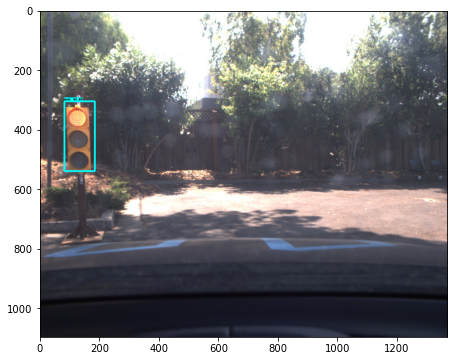

Red 0.9336655
Distance (metres) 3.0
Time in milliseconds 7992.006301879883 



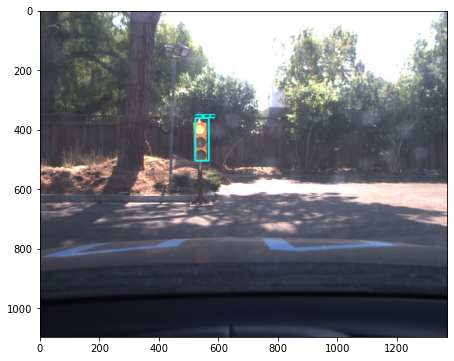

Red 0.9997281
Distance (metres) 5.0
Time in milliseconds 212.06259727478027 



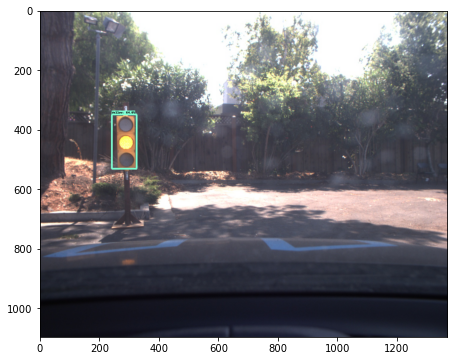

Yellow 0.64059454
Distance (metres) 3.0
Time in milliseconds 136.95502281188965 



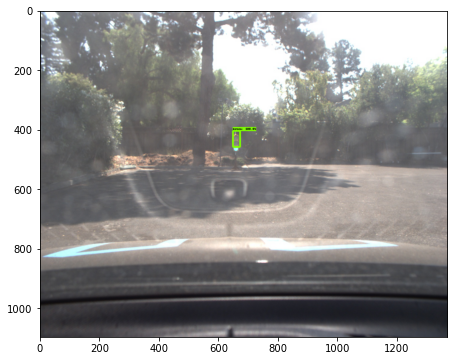

Green 0.9972763
Distance (metres) 12.0
Time in milliseconds 117.49649047851562 



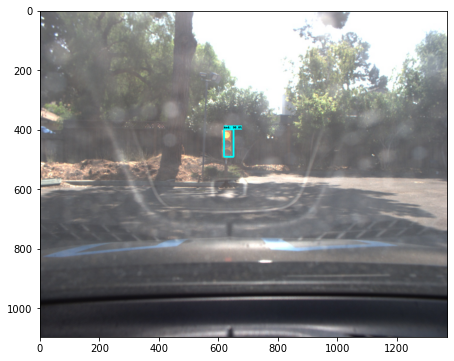

Red 0.90399116
Distance (metres) 8.0
Time in milliseconds 132.44032859802246 



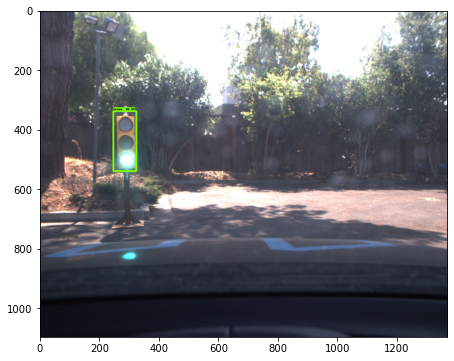

Green 0.7965602
Distance (metres) 3.0
Time in milliseconds 103.68967056274414 



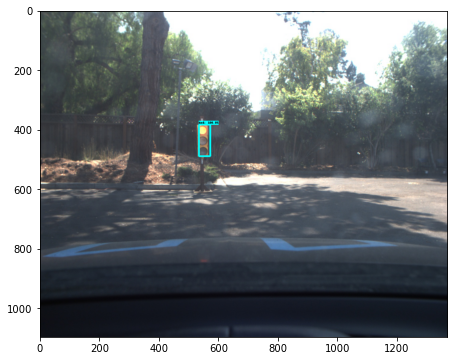

Red 0.9997869
Distance (metres) 6.0
Time in milliseconds 105.83043098449707 



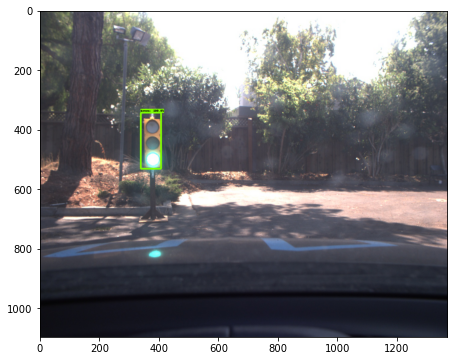

Green 0.99952114
Distance (metres) 4.0
Time in milliseconds 107.15723037719727 



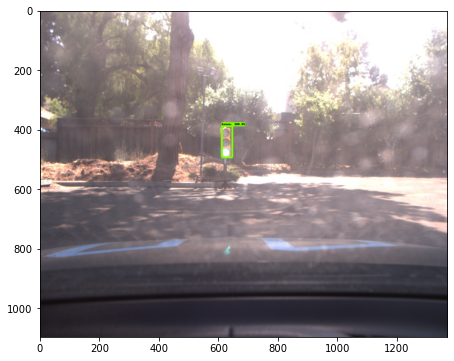

Green 0.9993377
Distance (metres) 7.0
Time in milliseconds 102.66637802124023 



In [65]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            image_np_expanded = gamma_correct(image_np_expanded,0.5)
            
            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
   
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .10
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")